In [1]:
import pandas as pd
import numpy as np
import pickle
import pprint
from scipy.stats import kurtosis, skew
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import load_model
from sklearn import metrics
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
INPUT_DATA = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

DATA_FILES = [
    "neutral_hazmei_2mins",
    "jumping_hazmei_1mins",
    "wave_hands_hazmei_1min"
]

LABELS = [
    "HAZMEI'S SEXY POSE", 
    "HAZMEI'S BELLY BOUNCE", 
    "HAZMEI'S FLYING KISS"
] 

TRAINING_SIZE = 1200
TESTING_SIZE = 300
WINDOW_SIZE = 1 #1 second
WINDOW_READINGS = WINDOW_SIZE * 50 #50Hz

In [3]:
def normalize_data(data):
    data_norm = (data - data.mean()) / (data.max() - data.min())
    return data_norm

def feature_extraction(x, y, z):
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    return features

def add_noise(data):
    data_noise = data + np.random.uniform(size=len(data))
    data_noise = data_noise + np.random.laplace(loc=0.0, scale=1.0, size=len(data))
    return data_noise

def data_augmentation(X):
    X_noise = X
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            X_noise[i][:][j] = add_noise(X_noise[i][:][j])
    return np.concatenate((X, X_noise), axis=0)

def feature_selection(X, augmentData=False):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            
            if augmentData:
                x_noise = add_noise(x)
                y_noise = add_noise(y)
                z_noise = add_noise(z)
                features.append(feature_extraction(x_noise, y_noise, z_noise))
            else:
                features.append(feature_extraction(x, y, z))

        data.append(features)
    return np.array(data)

def feature_engineering(X, augmentData=False):
    if augmentData:
        return np.concatenate((feature_selection(X, False), feature_selection(X, True)), axis=0)
    else:
        return feature_selection(X, False)
    
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_ - 1

def read_data(X_input_file_paths):
    X = np.zeros([1,WINDOW_READINGS,9])
    Xt = np.zeros([1,WINDOW_READINGS,9])
    y = []
    yt = []
    count = 0
    for file in X_input_file_paths:
        raw_data = pd.read_csv(file + ".txt", header=None, delim_whitespace=True)
        data = raw_data.loc[:, raw_data.columns != 0]
        data = data.values.reshape(-1, 9)
        data = data[:data.shape[0]-(data.shape[0]%WINDOW_READINGS)]
        normalized_data = normalize_data(data)
        sampled_data = normalized_data.reshape(-1, WINDOW_READINGS, 9)
        print(normalized_data.shape)
        print(sampled_data.shape)
        X = np.concatenate((X, sampled_data[:sampled_data.shape[0]-10]), axis=0)
        Xt = np.concatenate((Xt, sampled_data[sampled_data.shape[0]-10:]), axis=0)
        y = y + [count]*(sampled_data.shape[0]-10)
        yt = yt + [count]*(sampled_data.shape[0]-(sampled_data.shape[0]-10))
        np.savetxt('data/data_hazmei/y.txt', y, fmt='%5s', delimiter=" ")
        np.savetxt(file + "_formatted.csv", data[0:], delimiter=",")
        count = count + 1
    y = np.array(y)
    yt = np.array(yt)
    return X[1:], y, Xt[1:], yt


In [4]:
X_input_file_paths = ['data/data_hazmei/' + filename for filename in DATA_FILES]
X, Y, Xt, Yt = read_data(X_input_file_paths)
print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

#raw_data = pd.read_csv('data/data_hazmei/jumping_hazmei_1mins.txt', header=None, delim_whitespace=True)
#print(raw_data.shape)
#print(raw_data[0:])
#pure_data = raw_data.loc[:, raw_data.columns != 0]
#print(pure_data.shape)
#print(pure_data[0:])
#data = pure_data.values.reshape(-1, 9)
#data = data[:data.shape[0]-(data.shape[0]%50)]
#data = normalize_data(data)
#print(data.shape)
#print(data[0:])
#cropped_data = data.reshape(-1, 50, 9)
#print(cropped_data.shape)
#print(cropped_data)
#np.savetxt("data/data_hazmei/formatted_data.csv", data[0:], delimiter=",")

(5400, 9)
(108, 50, 9)
(2700, 9)
(54, 50, 9)
(2800, 9)
(56, 50, 9)
(188, 50, 9)
(188,)
(30, 50, 9)
(30,)


In [5]:
'''
X_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]
X_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]
X_train = load_X(X_train_input_paths)
X_test = load_X(X_test_input_paths)

y_train_path = "data/y_train.txt"
y_test_path = "data/y_test.txt"
Y_train = load_y(y_train_path).ravel()
Y_test = load_y(y_test_path).ravel()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(X_train[0])
print(Y_train[0])

X_train = X_train[0:TRAINING_SIZE]
Y_train = Y_train[0:TRAINING_SIZE]
X_test = X_test[0:TESTING_SIZE]
Y_test = Y_test[0:TESTING_SIZE]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
'''

'\nX_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]\nX_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]\nX_train = load_X(X_train_input_paths)\nX_test = load_X(X_test_input_paths)\n\ny_train_path = "data/y_train.txt"\ny_test_path = "data/y_test.txt"\nY_train = load_y(y_train_path).ravel()\nY_test = load_y(y_test_path).ravel()\n\nprint(X_train.shape)\nprint(Y_train.shape)\nprint(X_test.shape)\nprint(Y_test.shape)\n\nprint(X_train[0])\nprint(Y_train[0])\n\nX_train = X_train[0:TRAINING_SIZE]\nY_train = Y_train[0:TRAINING_SIZE]\nX_test = X_test[0:TESTING_SIZE]\nY_test = Y_test[0:TESTING_SIZE]\n\nprint(X_train.shape)\nprint(Y_train.shape)\nprint(X_test.shape)\nprint(Y_test.shape)\n'

In [6]:
#Raw Data with Data Augmentation
'''
X = data_augmentation(X)
Xt = data_augmentation(Xt)
Y = np.concatenate((Y, Y), axis=0)
Yt = np.concatenate((Yt, Yt), axis=0)
'''

#Feature Selection & Data Augmentation
'''
X = feature_engineering(X, False)
Xt = feature_engineering(Xt, False)
#Y = np.concatenate((Y, Y), axis=0)
#Yt = np.concatenate((Yt, Yt), axis=0)
'''




Yhot = to_categorical(Y)

print(X.shape)
print(Xt.shape)
print(Yhot.shape)
#print(X[0])

np.savetxt("data/test_data_format.csv", Xt[0], delimiter=",")

#X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
#Xt = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])


(188, 50, 9)
(30, 50, 9)
(188, 3)


In [7]:
#Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LSTM(16, return_sequences=True))
#model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=30, batch_size=b_size, validation_split=0.0, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))


Epoch 1/30
188/188 [==============================] - 1s - loss: 1.0959 - acc: 0.4202     
Epoch 2/30
188/188 [==============================] - 1s - loss: 1.0725 - acc: 0.5213     
Epoch 3/30
188/188 [==============================] - 1s - loss: 1.0332 - acc: 0.5213     
Epoch 4/30
188/188 [==============================] - 1s - loss: 0.9898 - acc: 0.5213     
Epoch 5/30
188/188 [==============================] - 1s - loss: 0.9749 - acc: 0.5213     
Epoch 6/30
188/188 [==============================] - 1s - loss: 0.9375 - acc: 0.5213     
Epoch 7/30
188/188 [==============================] - 1s - loss: 0.8829 - acc: 0.5266     
Epoch 8/30
188/188 [==============================] - 1s - loss: 0.8082 - acc: 0.5904     
Epoch 9/30
188/188 [==============================] - 1s - loss: 0.6769 - acc: 0.7287     
Epoch 10/30
188/188 [==============================] - 1s - loss: 0.4843 - acc: 0.8777     
Epoch 11/30
188/188 [==============================] - 1s - loss: 0.2761 - acc: 0.9468   

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Accuracy Rate:
1.0
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]

Confusion matrix (normalised to % of total test data):
[[ 33.33333588   0.           0.        ]
 [  0.          33.33333588   0.        ]
 [  0.           0.          33.33333588]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


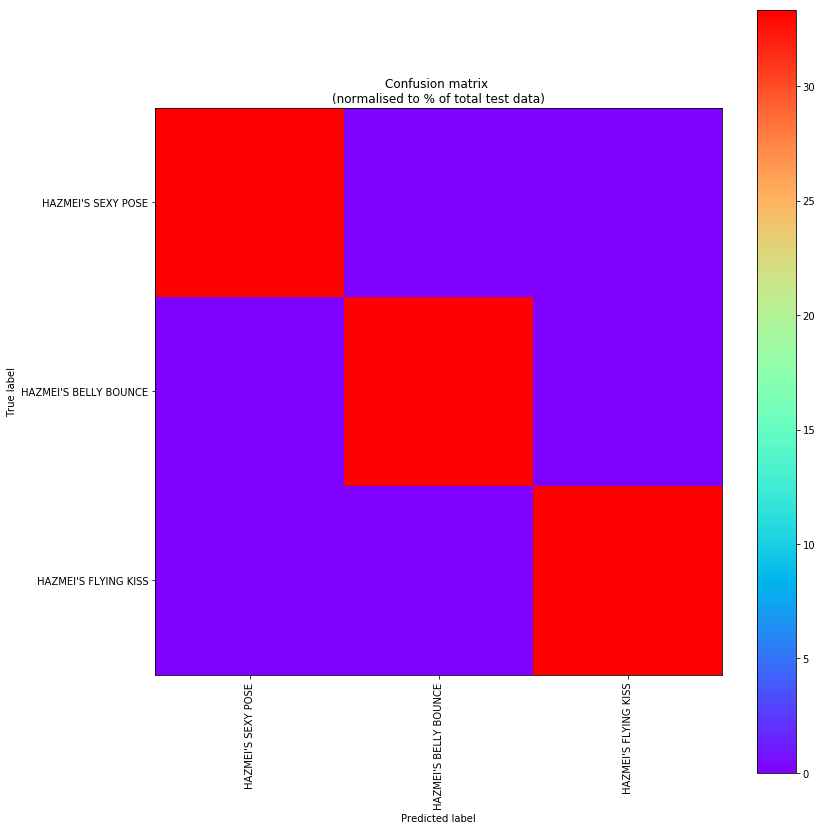

In [8]:
Y_output = model.predict(Xt)
Y_pred = np.argmax(Y_output, axis=1)
print(np.array(Y_pred))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

np.savetxt("data/accuracy.csv", [metrics.accuracy_score(Yt, Y_pred)], delimiter=",")
np.savetxt("data/confusion_matrix.csv", metrics.confusion_matrix(Yt, Y_pred), delimiter=",")


In [9]:
model.save('data/har_rnn_lstm.h5')  # creates a HDF5 file 'my_model.h5'

In [10]:
raw_data = pd.read_csv('data/sample_data_format.csv', skiprows=range(0, 7))
print(raw_data.shape)
cropped_data = raw_data.values.reshape(-1, 40, 9)
print(cropped_data.shape)
print(cropped_data)
pickle.dump(cropped_data, open('data/cropped_data_format.pkl', 'wb'))
np.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")


(120, 9)
(3, 40, 9)
[[[  3.30674392e-03   4.08453215e-03   3.11877709e-02 ...,   1.01641703e+00
    -1.25868201e-01   1.02473199e-01]
  [  7.57194078e-03   5.11844782e-03   2.35671904e-02 ...,   1.02074504e+00
    -1.24368198e-01   9.75658968e-02]
  [  5.40711684e-03   5.89226792e-03   2.10004691e-02 ...,   1.01864302e+00
    -1.23138197e-01   9.76466537e-02]
  ..., 
  [  2.28138897e-03  -4.51477198e-03  -2.35145297e-02 ...,   1.01842904e+00
    -1.24303102e-01   1.02193497e-01]
  [  3.65372794e-03  -5.92592312e-03  -1.84824299e-02 ...,   1.01989496e+00
    -1.25629902e-01   1.07519001e-01]
  [  2.31263903e-03  -5.06280502e-03  -1.73001904e-02 ...,   1.01864696e+00
    -1.24689601e-01   1.08948000e-01]]

 [[ -4.04219390e-05  -2.24447693e-03  -1.92251801e-02 ...,   1.01638699e+00
    -1.21801399e-01   1.07225001e-01]
  [  5.34225372e-04  -7.86087825e-04  -2.20926702e-02 ...,   1.01705301e+00
    -1.20280102e-01   1.04516402e-01]
  [  2.96326308e-03  -1.21828204e-03  -2.44254097e-02 ...,